## Import Libraries

Import all the required Libraries

In [105]:

import os
import pandas as pd

from functools import reduce

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

import nltk
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np  
import re  
import nltk 

import time

import math
 
import pickle  
from nltk.corpus import stopwords

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.utils.extmath import density
from sklearn import metrics

from sklearn.decomposition import PCA

from keras.utils import to_categorical

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold

from collections import Counter

In [160]:
import warnings
warnings.filterwarnings("ignore")

In [151]:
# Ablation Experiment
ablation = False
ablation_ratio = 0.15

# how many unique words to use (i.e num rows in embedding vector)
max_features = 120000
# Percentile of Padding to use with Tokenized words
pad_percentile = 50

# Use Keras Tokenizer
use_tokenizer = False
use_tf_idf = True

text_col = 'lower_text'

pca_components = 300

numpy_seed = 478

seed = 7
n_splits = 10
scoring = 'neg_log_loss'



## Create Train and Test DF

Create Training and Testing Data Frames

In [108]:

#ROOT_DIR = r'/Users/shabhushan/Desktop/python/python-code/dataset/notracking/participants'
ROOT_DIR = r'/home/shashi/Desktop/projects/python-code/dataset/notracking/participants'
TRAIN_LABELS = os.path.join(ROOT_DIR, r'train', r'labels', r'labels.csv')
TRAIN_TEXT = os.path.join(ROOT_DIR, r'train', r'extracted_data', r'extract_combined.csv')
TEST_TEXT = os.path.join(ROOT_DIR, r'test', r'extracted_data', r'extract_combined.csv')


In [109]:

# read in training and testing data
# one dataframe for labels another for text features
train_labels_df = pd.read_csv(TRAIN_LABELS, usecols=['document_name','is_fitara'])
train_text_df = pd.read_csv(TRAIN_TEXT)
test_df = pd.read_csv(TEST_TEXT)

# combine labels with text features
train_df = pd.merge(
    train_labels_df, 
    train_text_df, 
    on='document_name', 
    how='inner'
)

# remove dataframes that are no longer needed from memory 
del train_labels_df
del train_text_df


In [110]:
train_df['is_fitara'] = train_df['is_fitara'].map({'No': 0, 'Yes': 1})

# Util Functions

Some Utility Functions 

In [111]:
def get_set_from_word_list(lst):
    temp_set_list = [set(nltk.word_tokenize(words)) for words in lst]

    return reduce(lambda x, y: {*x, *y}, temp_set_list)

In [112]:
#set_no = get_set_from_word_list(train_df_temp)
def get_word_frequency(df):
    tokenized_words = [nltk.word_tokenize(words) for words in df]
    words_list = reduce(lambda x, y: [*x, *y], tokenized_words)

    vectorizer = CountVectorizer(stop_words='english')
    vectorizer.fit_transform(words_list)

    return pd.DataFrame(vectorizer.vocabulary_.items(), columns=['Text', 'Frequency']).sort_values(by='Frequency', ascending=False)

In [113]:
def get_tf_idf(train_df, test_df):
    vectorizer = TfidfVectorizer(stop_words='english', use_idf=True)
    X_train = vectorizer.fit_transform(train_df)
    
    X_test = vectorizer.transform(test_df)

    return X_train, X_test, vectorizer.get_feature_names() #pd.DataFrame(X.toarray(), columns = vectorizer.get_feature_names()), X

In [114]:
def lemmatize(words):
    """
        Break a Sentence into words, remove Stop words keeping only alphabet and numbers, remove
        punctuations, comma etc. and at the end Lemmatize the words.
    """
    tokenized_words = nltk.word_tokenize(words)
    
    # Remove Stop words and keep only Alpha Numeric words
    words = [word for word in tokenized_words if word.lower() not in stop_words]
    
    words = [word for word in words if word.isalnum() and not word.isdigit()]

    pos_tags = nltk.pos_tag(words)
    return ' '.join([lemma.lemmatize(token, tag_map[tag[0]]) for token, tag in pos_tags])

In [115]:
def add_features(df):
    """
        Add Extra Features to the Data Frame
        
        text: convert to string
        lower_text: lowers the text
        total_length: length of the document
        capitals: number of capitals in document
        caps_vs_length: ratio of capital words to total length
        num_words: number of words in document.
        num_unique_words: number of unique words in document
        words_vs_unique: number of unique words in document
        document_type: whether the docoment is pdf, doc or docx
    """
    df['text'] = df['text'].apply(lambda x:str(x))
    df["lower_text"] = df["text"].apply(lambda x: x.lower())
    df['total_length'] = df['text'].apply(len)
    df['capitals'] = df['text'].apply(lambda comment: sum(1 for c in comment if c.isupper()))
    df['caps_vs_length'] = df.apply(lambda row: float(row['capitals'])/float(row['total_length']),
                                axis=1)
    df['num_words'] = df.text.str.count('\S+')
    df['num_unique_words'] = df['text'].apply(lambda comment: len(set(w for w in comment.split())))
    df['words_vs_unique'] = df['num_unique_words'] / df['num_words'] 
    df['document_type'] = df['document_name'].apply(lambda val: val.split(".")[-1])
    return df

In [116]:
train_df = add_features(train_df)
test_df = add_features(test_df)

## NLTK Tokenization and Lemmatization

First, we need to remove the stop words, punctuation characters and all other special characters from the text.
Then, we need to lemmatize the word to it's root form.

In [117]:
from nltk.stem.wordnet import WordNetLemmatizer
from collections import defaultdict
from nltk.corpus import wordnet as wn

# English Stop Words list
stop_words = set(nltk.corpus.stopwords.words('english'))

# Create a Tag Dictionary, Default tag is Noun
tag_map = defaultdict(lambda : wn.NOUN)
tag_map['J'] = wn.ADJ
tag_map['V'] = wn.VERB
tag_map['R'] = wn.ADV

# Get a Lemmatizer
lemma = WordNetLemmatizer()

In [118]:
%%time

train_df[text_col] = train_df[text_col].apply(lemmatize)
test_df[text_col] = test_df[text_col].apply(lemmatize)

CPU times: user 4min 52s, sys: 216 ms, total: 4min 52s
Wall time: 4min 52s


In [119]:
train_df.to_csv(os.path.join(ROOT_DIR, r'train', r'train.csv'), index = False)
test_df.to_csv(os.path.join(ROOT_DIR, r'test', r'test.csv'), index = False)

In [120]:
train_df = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train.csv'))
test_df = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test.csv'))

In [121]:
to_drop = ['document_name', 'text']
train_df.drop(to_drop, axis=1, inplace=True)
test_df.drop(to_drop, axis=1, inplace=True)

## EDA

Primilinary Exploratory Data Analysis

Since Positive and Negative classes are size 71% and 29% respectively. Hence, no severe class imbalance.

In [122]:

# confirm class distribution
# is_fitara - yes: ~29%; no: ~71%
train_df['is_fitara'].value_counts(normalize=True)


0    0.713089
1    0.286911
Name: is_fitara, dtype: float64

In [123]:
%%time

def get_top_words_list(df):
    word_list = []

    df['lower_text'].map(lambda row: word_list.extend(row.split()))

    counter_df = pd.DataFrame.from_dict(Counter(word_list), orient='index').reset_index()

    counter_df.columns = ['word', 'frequency']

    return counter_df.sort_values(by = 'frequency', ascending = False)

def plot_top_words(df):
    top_counter_df_no = get_top_words_list(df[df.is_fitara == 0])
    top_counter_df_yes = get_top_words_list(df[df.is_fitara == 1])
    
    exclusive_no = set(top_counter_df_no['word'].values) - set(top_counter_df_yes['word'].values)
    exclusive_yes = set(top_counter_df_yes['word'].values) - set(top_counter_df_no['word'].values)
    
    english_words = set(nltk.corpus.words.words())
    
    # Keep Only common words 
    exclusive_no = [word for word in exclusive_no if word in english_words]
    exclusive_yes = [word for word in exclusive_yes if word in english_words]
    
    exclusive_no_df = top_counter_df_no[top_counter_df_no['word'].isin(exclusive_no)]
    exclusive_yes_df = top_counter_df_yes[top_counter_df_yes['word'].isin(exclusive_yes)]
    
    plt.figure(figsize=(20,12))
    sns.barplot(x = 'word', y = 'frequency', data = exclusive_no_df.head(25))
    plt.plot()
    plt.figure(figsize=(20,12))
    sns.barplot(x = 'word', y = 'frequency', data = exclusive_yes_df.head(25))
    plt.plot()
    
    #return exclusive_no_df, exclusive_yes_df
    #return top_counter_df_no, top_counter_df_yes, exclusive_no, exclusive_no, exclusive_no_df, exclusive_yes_df

#plot_top_words(train_df)

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 7.39 µs


### Handle Categorical Variables

In [124]:
train_df = pd.concat([train_df, pd.get_dummies(train_df['document_type'])], axis=1)
train_df.drop(['document_type'], axis=1, inplace=True)

### Ablation

In [125]:
if ablation:
    train_df_no = train_df[train_df.is_fitara == 0]
    train_df_yes = train_df[train_df.is_fitara == 1]

    # Get 15% of total Records for Ablation
    train_df_no_ablation = train_df_no.loc[0:int(len(train_df_no) * ablation_ratio)]
    train_df_yes_ablation = train_df_yes.loc[0:int(len(train_df_yes) * ablation_ratio)]
    
    # Shuffle rows and reset index
    train_df = pd.concat([train_df_yes_ablation, train_df_no_ablation]).sample(frac=1).reset_index(drop=True)

### Train Test Split

In [126]:
X = train_df.drop(['is_fitara'], axis=1)
y = train_df['is_fitara']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

### TF IDF

In [127]:
if use_tf_idf:
    X_train_tf, X_test_tf, feature_names = get_tf_idf(X_train[text_col], X_test[text_col])

    X_train_df = pd.DataFrame(X_train_tf.toarray(), columns = feature_names, index = X_train.index)
    X_test_df = pd.DataFrame(X_test_tf.toarray(), columns = feature_names, index = X_test.index)

    X_train = pd.concat([X_train, X_train_df], axis=1)
    X_test = pd.concat([X_test, X_test_df], axis=1)

    X_train.drop([text_col], axis=1, inplace=True)
    X_test.drop([text_col], axis=1, inplace=True)

### Tokenize the Strings

In [128]:
if use_tokenizer:
    ## Tokenize the sentences
    tokenizer = Tokenizer(num_words=max_features)
    tokenizer.fit_on_texts(list(X_train[text_col]))
    X_train[text_col] = tokenizer.texts_to_sequences(X_train[text_col])
    X_test[text_col] = tokenizer.texts_to_sequences(X_test[text_col])

### Pad the sentences 

In [129]:
if use_tokenizer:
    # Find Max Length
    train_max_len = np.percentile(X_train[text_col].apply(len), pad_percentile)
    test_max_len = np.percentile(X_test[text_col].apply(len), pad_percentile)

    max_len = int(test_max_len if train_max_len < test_max_len else train_max_len)

    # Pad the Sentences
    X_train_temp = pd.DataFrame(pad_sequences(X_train[text_col], maxlen=max_len), index = X_train.index)
    X_test_temp = pd.DataFrame(pad_sequences(X_test[text_col], maxlen=max_len), index = X_test.index)

    # Remove Existing DF
    X_train.drop([text_col], axis=1, inplace=True)
    X_test.drop([text_col], axis=1, inplace=True)

    # Create new DF
    X_train = pd.concat([X_train_temp, X_train], axis = 1)
    X_test = pd.concat([X_test_temp, X_test], axis = 1)

### Standard Scaler Transformation

In [130]:
scaler = StandardScaler()

if use_tokenizer:
    cols = X_train.columns
elif use_tf_idf:
    cols = ['total_length','capitals','caps_vs_length','num_words','num_unique_words','words_vs_unique']

train_features = X_train[cols].values
test_features = X_test[cols].values

scaler.fit(train_features)

train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)

X_train[cols] = pd.DataFrame(train_features, columns = cols, index = X_train.index)
X_test[cols] = pd.DataFrame(test_features, columns = cols, index = X_test.index)

In [131]:
X_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_pad.csv'), index = False)
X_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_pad.csv'), index = False)

In [132]:
X_train = pd.read_csv(os.path.join(ROOT_DIR, r'train', r'train_pad.csv'))
X_test = pd.read_csv(os.path.join(ROOT_DIR, r'test', r'test_pad.csv'))

### Principle Component Analysis

In [152]:
standard_columns = ['total_length','capitals','caps_vs_length','num_words','num_unique_words','words_vs_unique', 'doc', 'docx', 'pdf']

cols = X_train.columns[len(standard_columns):]

pca = PCA(n_components = pca_components)

pca.fit(X_train[cols])

print(f"Variance Explained by Model is {pca.explained_variance_ratio_.cumsum()[-1]}")

Variance Explained by Model is 0.8969187327000945


In [153]:
standard_columns = ['total_length','capitals','caps_vs_length','num_words','num_unique_words','words_vs_unique', 'doc', 'docx', 'pdf']

cols = X_train.columns[len(standard_columns):]

pca = PCA(n_components = pca_components)

pca.fit(X_train[cols])

X_train_pca = pd.DataFrame(pca.transform(X_train[cols]))
X_test_pca = pd.DataFrame(pca.transform(X_test[cols]))

print(f"Variance Explained by Model is {pca.explained_variance_ratio_.cumsum()[-1]}")

Variance Explained by Model is 0.8971266557642221


In [154]:
# Remove Old Columns
X_train.drop(cols, axis=1, inplace=True)
X_test.drop(cols, axis=1, inplace=True)

# Append PCA Columns
X_train = pd.concat([X_train, X_train_pca], axis=1)
X_test = pd.concat([X_test, X_test_pca], axis=1)

In [167]:
X_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_pca.csv'), index = False)
y_train.to_csv(os.path.join(ROOT_DIR, r'train', r'train_label_pca.csv'), index = False)

X_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_pca.csv'), index = False)
y_test.to_csv(os.path.join(ROOT_DIR, r'test', r'test_label_pca.csv'), index = False)

### Model Building
First Try fitting a Simple Neural Network

In [177]:
# fix random seed for reproducibility
np.random.seed(576)

# create model
model = Sequential()
model.add(Dense(35, input_dim=X_train.shape[1], activation='sigmoid'))
model.add(Dropout(0.25))
model.add(Dense(18, activation='sigmoid'))
model.add(Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

#model = Sequential()
#model.add(Dense(35, input_dim=X_train.shape[1], activation='sigmoid'))
#model.add(Dropout(0.25))
#model.add(Dense(18, kernel_initializer='normal', activation='sigmoid'))
#model.add(Dense(2, kernel_initializer='normal', activation='sigmoid'))
# Compile model
#sgd = SGD(lr=0.01, momentum=0.8, decay=0.0, nesterov=False)
#model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])

# train model
history = model.fit(X_train, to_categorical(y_train, 2), epochs=400, batch_size=10, verbose=2)#, class_weight={1:0.96, 0:0.04})

Epoch 1/400
 - 0s - loss: 0.7340 - acc: 0.5209
Epoch 2/400
 - 0s - loss: 0.6076 - acc: 0.6969
Epoch 3/400
 - 0s - loss: 0.6022 - acc: 0.6969
Epoch 4/400
 - 0s - loss: 0.5985 - acc: 0.6969
Epoch 5/400
 - 0s - loss: 0.5857 - acc: 0.6969
Epoch 6/400
 - 0s - loss: 0.5827 - acc: 0.6927
Epoch 7/400
 - 0s - loss: 0.5812 - acc: 0.6927
Epoch 8/400
 - 0s - loss: 0.5694 - acc: 0.6899
Epoch 9/400
 - 0s - loss: 0.5559 - acc: 0.6941
Epoch 10/400
 - 0s - loss: 0.5512 - acc: 0.6913
Epoch 11/400
 - 0s - loss: 0.5361 - acc: 0.7025
Epoch 12/400
 - 0s - loss: 0.5227 - acc: 0.7402
Epoch 13/400
 - 0s - loss: 0.5117 - acc: 0.7346
Epoch 14/400
 - 0s - loss: 0.4855 - acc: 0.7612
Epoch 15/400
 - 0s - loss: 0.4661 - acc: 0.7682
Epoch 16/400
 - 0s - loss: 0.4522 - acc: 0.7849
Epoch 17/400
 - 0s - loss: 0.4425 - acc: 0.8198
Epoch 18/400
 - 0s - loss: 0.4118 - acc: 0.8142
Epoch 19/400
 - 0s - loss: 0.3912 - acc: 0.8310
Epoch 20/400
 - 0s - loss: 0.3899 - acc: 0.8240
Epoch 21/400
 - 0s - loss: 0.3444 - acc: 0.8603
E

Epoch 171/400
 - 0s - loss: 0.1212 - acc: 0.9441
Epoch 172/400
 - 0s - loss: 0.1319 - acc: 0.9330
Epoch 173/400
 - 0s - loss: 0.1203 - acc: 0.9455
Epoch 174/400
 - 0s - loss: 0.1206 - acc: 0.9413
Epoch 175/400
 - 0s - loss: 0.1272 - acc: 0.9469
Epoch 176/400
 - 0s - loss: 0.1206 - acc: 0.9399
Epoch 177/400
 - 0s - loss: 0.1363 - acc: 0.9302
Epoch 178/400
 - 0s - loss: 0.1173 - acc: 0.9441
Epoch 179/400
 - 0s - loss: 0.1208 - acc: 0.9399
Epoch 180/400
 - 0s - loss: 0.1153 - acc: 0.9469
Epoch 181/400
 - 0s - loss: 0.1159 - acc: 0.9497
Epoch 182/400
 - 0s - loss: 0.1213 - acc: 0.9455
Epoch 183/400
 - 0s - loss: 0.1208 - acc: 0.9413
Epoch 184/400
 - 0s - loss: 0.1270 - acc: 0.9427
Epoch 185/400
 - 0s - loss: 0.1246 - acc: 0.9469
Epoch 186/400
 - 0s - loss: 0.1231 - acc: 0.9427
Epoch 187/400
 - 0s - loss: 0.1320 - acc: 0.9302
Epoch 188/400
 - 0s - loss: 0.1213 - acc: 0.9525
Epoch 189/400
 - 0s - loss: 0.1273 - acc: 0.9455
Epoch 190/400
 - 0s - loss: 0.1244 - acc: 0.9358
Epoch 191/400
 - 0s 

 - 0s - loss: 0.0883 - acc: 0.9623
Epoch 339/400
 - 0s - loss: 0.0861 - acc: 0.9581
Epoch 340/400
 - 0s - loss: 0.0864 - acc: 0.9567
Epoch 341/400
 - 0s - loss: 0.0837 - acc: 0.9637
Epoch 342/400
 - 0s - loss: 0.0880 - acc: 0.9567
Epoch 343/400
 - 0s - loss: 0.0862 - acc: 0.9609
Epoch 344/400
 - 0s - loss: 0.0903 - acc: 0.9511
Epoch 345/400
 - 0s - loss: 0.1044 - acc: 0.9469
Epoch 346/400
 - 0s - loss: 0.0818 - acc: 0.9637
Epoch 347/400
 - 0s - loss: 0.0790 - acc: 0.9679
Epoch 348/400
 - 0s - loss: 0.0816 - acc: 0.9567
Epoch 349/400
 - 0s - loss: 0.0817 - acc: 0.9679
Epoch 350/400
 - 0s - loss: 0.0786 - acc: 0.9693
Epoch 351/400
 - 0s - loss: 0.0696 - acc: 0.9665
Epoch 352/400
 - 0s - loss: 0.0797 - acc: 0.9665
Epoch 353/400
 - 0s - loss: 0.0808 - acc: 0.9609
Epoch 354/400
 - 0s - loss: 0.0788 - acc: 0.9637
Epoch 355/400
 - 0s - loss: 0.0932 - acc: 0.9539
Epoch 356/400
 - 0s - loss: 0.0782 - acc: 0.9623
Epoch 357/400
 - 0s - loss: 0.0884 - acc: 0.9553
Epoch 358/400
 - 0s - loss: 0.0830

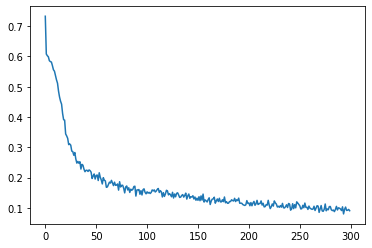

In [157]:
# plot metrics
plt.plot(history.history['loss'])
plt.show()

In [178]:
y_pred = model.predict(X_test)

num_train = metrics.log_loss(y_train.values, model.predict(X_train))
num_test = metrics.log_loss(y_test.values, y_pred)

print(f"Log Loss on Train is {num_train} and exponential is {math.exp(-num_train)}.\
      \nLog Loss on Test is {num_test} and exponential is {math.exp(-num_test)}.\
      \nAccuracy Score is {metrics.accuracy_score(y_test, y_pred)}")

ValueError: Classification metrics can't handle a mix of binary and continuous-multioutput targets

Let's check cross validation score for different algorithms on training Data

LR: 0.814124 ( +- 0.047975) 
 Log Loss : 6.214130
 Accuracy : 0.820084
NB: 0.731808 ( +- 0.062670) 
 Log Loss : 8.526439
 Accuracy : 0.753138
LDA: 0.773631 ( +- 0.065906) 
 Log Loss : 4.335448
 Accuracy : 0.874477
KNN: 0.751526 ( +- 0.060058) 
 Log Loss : 7.948358
 Accuracy : 0.769874
TREE: 0.762422 ( +- 0.054644) 
 Log Loss : 7.225766
 Accuracy : 0.790795
CART: 0.808685 ( +- 0.062181) 
 Log Loss : 5.636045
 Accuracy : 0.836820
NB: 0.710974 ( +- 0.057141) 
 Log Loss : 7.514843
 Accuracy : 0.782427
SVM: 0.696811 ( +- 0.056324) 
 Log Loss : 8.237281
 Accuracy : 0.761506


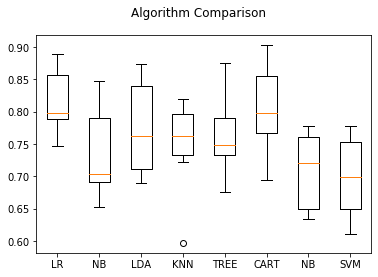

In [176]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.model_selection import cross_val_predict

estimators = []

estimators.append(('LR', LogisticRegression()))
estimators.append(('NB', BernoulliNB(alpha=.01)))
estimators.append(('LDA', LinearDiscriminantAnalysis()))
estimators.append(('KNN', KNeighborsClassifier()))
estimators.append(('TREE', DecisionTreeClassifier()))
estimators.append(('CART', RandomForestClassifier(n_estimators=100)))
estimators.append(('NB', GaussianNB()))
estimators.append(('SVM', SVC(probability=True)))

# evaluate each model in turn
results = []
names = []
for name, model in estimators:
    kfold = model_selection.KFold(n_splits=10, random_state=7)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    #cv_results = model_selection.cross_val_predict(model, X_train, y_train, cv=kfold)
    
    results.append(cv_results)
    names.append(name)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    log_loss = metrics.log_loss(y_test, y_pred)
    accuracy = metrics.accuracy_score(y_test, y_pred)
    
    msg = "%s: %f ( +- %f) \n Log Loss : %f\n Accuracy : %f" % (name, cv_results.mean(), cv_results.std(), log_loss, accuracy)
    print(msg)
    
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()